## TO-DO/BUGS/Considerations

### BUGS

- When introducing the ECG as feature, the prediction gives nan values. Need to try to implement a single feature LSTM autoencoder on the ECG and see if the behaviour is different

- Pad sequences with the mean of the feature may force the autoencoder to learn the mean instead the original ditribution. This problem occurs with HR,RR and DBP. TIME_STEP has to be setted to minimum lenght of features sequences.


### TO-DO

- Describe methodology: holdout method, preprocessing, multivariate lstm autoencoder, loss function (mse), reconstruction error, time for training, mean reconstructino error approach and adaptive thresholding based on it. Experimental results.

- 'if item > 0' condition when flattening inside normalization functions should be in clean_data function


### Questions

- Should I use also the std of reconstruction error for threshold estimation, as described in the work Adaptive Threshold for Outlier Detection on Data Streams?

### Considerations

- Nel caricare i dati la maggior parte dei sample era costituito da valori NaN. Una volta rimossi si ottengono dei valori con dei picchi, dovuti all'aver reso contigui valori che prima non lo erano.
- Rimossi i record che hanno una lunghezza pari a zero o una media negativa.
- TIME_STEP maggiori degradano le prestazioni

# Data prep


## Environment setup

In [3]:
import vitaldb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import operator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
import tensorflow as tf

from keras import regularizers
from seaborn import histplot



## Data load

### API data load

In [4]:

def load_from_API(n_cases=None, asa = 3 , op = '<'):

    """ 
    This function loads the VitalDB data from APIs

    INPUT

    - n_cases: limit the number of samples to load
    - asa: ASA status for health status classification, can range in [1,2,3,4,5,6]
    - op: operator to use on asa status. Permits to load a specific portion of the dataset.
    
     
    OUTPUT  

    - dbp: diastolyc blood pressure samples
    - sbp: systolic blood pressure samples
    - bt: body temperature samples
    - hr: heart rate samples
    - rr: respiratory rate samples

    """

    ops = {'>': operator.gt,
       '<': operator.lt,
       '>=': operator.ge,
       '<=': operator.le,
       '==': operator.eq}

    caseids_all = vitaldb.find_cases(['ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    
    df = pd.read_csv('https://api.vitaldb.net/cases') # Load dataset
    df = df[ops[op](df['asa'], asa)] # ASA param identifies the health status of the patient

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

     # load all the patients data 
    for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
        try:
            vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
            dbp.append(vals[:,0])
            sbp.append(vals[:,1])
            bt.append(vals[:,2])
            hr.append(vals[:,3])
            rr.append(vals[:,4])
            # extract non-null values
            dbp[i] = dbp[i][~np.isnan(dbp[i])]  
            sbp[i] = sbp[i][~np.isnan(sbp[i])] 
            bt[i] = bt[i][~np.isnan(bt[i])]
            hr[i] = hr[i][~np.isnan(hr[i])] 
            rr[i] = rr[i][~np.isnan(rr[i])]
        except Exception as e: 
            print('\n=================\n')
            print('INDEX: '+str(i))
            print('ERROR: '+str(type(e)))
            print('\n=================\n')
            pass

    
    return dbp,sbp,bt,hr,rr



### Disk data load

In [5]:
def load_from_disk(path,name='numeric_data.vitaldb'):
    
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

# save the data into a file since loading all the 2k caseids requires at least 1h
    filepath = os.path.join(path,name)

    with open(filepath, 'rb') as f:
        (dbp,sbp,bt,hr,rr) = pickle.load(f)
    
    return dbp,sbp,bt,hr,rr

In [6]:
def save_to_disk(path,dbp,sbp,bt,hr,rr):
# save the data into a file since loading all the 2k caseids requires at least 1h

    with open(os.path.join(path,'numeric_data.vitaldb'), 'wb') as f:
        pickle.dump((dbp,sbp,bt,hr,rr), f)


### Visualize

In [7]:
def plot_data(dbp,sbp,bt,hr,rr,bins=10):
    """ 
    INPUT 

    - dbp: diastolyc blood pressure samples
    - sbp: systolic blood pressure samples
    - bt: body temperature samples
    - hr: heart rate samples
    - rr: respiratory rate samples

    """

    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist if item > 0 ],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist if item > 0],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt for item in sublist if item > 0],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist if item > 0],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist if item > 0],dtype='float64')
    

    plt.subplots_adjust(hspace=1.)
    plt.subplot(511)
    plt.title("DBP")
    plt.hist(flat_list_dbp,bins=bins)

    plt.subplots_adjust(hspace=1.)
    plt.subplot(512)
    plt.title("SBP")
    plt.hist(flat_list_sbp,bins=bins)

    plt.subplot(513)
    plt.title("Body temperature")
    plt.hist(flat_list_bt,bins=bins)

    plt.subplot(514)
    plt.title("Heart rate")
    plt.hist(flat_list_hr,bins=bins)

    plt.subplot(515)
    plt.title("Respiratory rate")
    plt.hist(flat_list_rr,bins=bins)
    plt.show()


def histogram(dbp,sbp,bt,rr,hr):

    """ 
    INPUT 

    - dbp: diastolyc blood pressure samples
    - sbp: systolic blood pressure samples
    - bt: body temperature samples
    - hr: heart rate samples
    - rr: respiratory rate samples

    """


    # remove all the negative values since these vital parameters can only be positive
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist if item > 0],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist if item > 0],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist if item > 0],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist if item > 0],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist if item > 0],dtype='float64')

    d = {}
    d['Dyastolic BP'] = flat_list_dbp[:]
    d['Systolic BP'] = flat_list_sbp[:]
    d['Heart rate'] = flat_list_hr[:]

    b = {}
    b['Body temperature'] = flat_list_bt[:]
    b['Respiratory rate'] = flat_list_rr[:]

    f,ax = plt.subplots(2,1,figsize=(10,10))
    histplot(d,binwidth=1,ax=ax[0])
    histplot(b,binwidth=1,ax=ax[1])


def plot_anomalies(X_test,res,threshold,log=False):

    plt.figure(figsize=(6,6))
    n = min(X_test.shape[0],res.shape[0])

    x = np.arange(0,n)
    t_line = np.zeros(n)
    if(log):
        thresh = np.log(threshold)
    else:
        thresh = threshold
    t_line[:] = thresh
    
    c = 0
    for p in range(0,n):
        re = (np.linalg.norm(X_test[p,...] - res[p,...],2))
        if(log):
            re = np.log(re)
        if(re >= thresh):
            c = c+1
            plt.scatter(p,re,c='r')
        else:
            plt.scatter(p,re,c='g')
    plt.plot(x,t_line,'b')
    plt.ylabel('Reconstruction error')
    plt.xlabel('Samples')
    plt.show()




def plot_features_anomalies(X_test,res,thresholds,log=False):

    n = min(X_test.shape[0],res.shape[0])
    n_features = min(X_test.shape[2],res.shape[2])
    x = np.arange(0,n)

    d = {}
    d[0] = 'Diastolic BP'
    d[1] = 'Systolic BP'
    d[2] = 'Body temperature'
    d[3] = 'Heart rate'
    d[4] = 'Respiratory rate'
    f,ax = plt.subplots(n_features,1,figsize=(20,10))
    

    for i in range(0,n_features):

        t_line = np.zeros(n)
        if(log):
            threshold = np.log(thresholds[i])
        else:
            threshold = thresholds[i]
        t_line[:] = threshold

        for p in range(0,n):
            re = np.linalg.norm(X_test[p,:,i] - res[p,:,i],2)
            if(log):
                re = np.log(re)
            if(re >= threshold):
                ax[i].scatter(p,re,c='r')
            else:
                ax[i].scatter(p,re,c='g')

        ax[i].plot(x,t_line,'b')
        ax[i].title.set_text(str(d[i]))
        ax[i].set_ylabel('Reconstruction error')
        ax[i].set_xlabel('Samples')
    plt.tight_layout()
    plt.show()


def plot_predict(X_test, res, figsize=(40,40), n = None, single = False, vals = None):

    """
    INPUT

    - X_test : data samples to plot
    - res_test: reconstructed data samples to plot
    - figsize: size of the plot
    - n: number of samples to plot
    - single: Boolean, when True plots the single instance number specified by 'n'
    - vals: List of indices of samples to plot

    """

    plt.figure(figsize=figsize)

   
    d = {}
    d[0] = 'Diastolic BP'
    d[1] = 'Systolic BP'
    d[2] = 'Body temperature'
    d[3] = 'Heart rate'
    d[4] = 'Respiratory rate'
    
    if(n is not None and isinstance(n,int) and n > -1):
        if(single):
            for j in range(0,5):
                s = '61'+str(j+1)
                plt.subplot(int(s))
                plt.subplots_adjust(hspace=1.)
                plt.title(d[j])
                plt.plot(res[n,:,j],'-r',linewidth=2.5,)
                plt.plot(X_test[n,:,j],'-g',linewidth=2.5,alpha=0.8)
            plt.show()
        else:
            for j in range(0,5):
                for i in range(0,n):
                    s = '61'+str(j+1)
                    plt.subplot(int(s))
                    plt.subplots_adjust(hspace=1.)
                    plt.title(d[j])
                    plt.plot(res[i,:,j],'-r',linewidth=2.5,)
                    plt.plot(X_test[i,:,j],'-g',linewidth=2.,alpha=0.5)
            plt.show()
    elif(vals is not None):
        for j in range(0,5):
            for i in vals:
                s = '61'+str(j+1)
                plt.subplot(int(s))
                plt.subplots_adjust(hspace=1.)
                plt.title(d[j])
                plt.plot(res[i,:,j],'-r',linewidth=2.5,)
                plt.plot(X_test[i,:,j],'-g',linewidth=2.,alpha=0.5)

        plt.show()
    else:
        n = X_test.shape[0]
        for j in range(0,5):
            for i in range(0,n):
                s = '61'+str(j+1)
                plt.subplot(int(s))
                plt.subplots_adjust(hspace=1.)
                plt.title(d[j])
                plt.plot(res[i,:,j],'-r',linewidth=2.5,)
                plt.plot(X_test[i,:,j],'-g',linewidth=2.,alpha=0.5)

        plt.show()




## Preprocessing

In [8]:
def clean_data(dbp,sbp,bt,hr,rr,raw = True):
    """ 
    This function removes time series records which have either zero length (empty record) or negative mean value (affected by registration noise)

    INPUT 

    - dbp: diastolyc blood pressure samples
    - sbp: systolic blood pressure samples
    - bt: body temperature samples
    - hr: heart rate samples
    - rr: respiratory rate samples

    OUTPUT: cleaned data

    NB: Blood pressure (dbp,sbp) ranges accordingly with the European guidelines ESC-ESH 2018.
        Body temperature ranges in 35-37 
        Hearth rate ranges in 60-100
        Respiratory rate ranges in 10-21

        These values for ranges are a bit wider than optimal ones since we want to preserve some variablity in the data. 
     
    """


    try:
        for i in range(0,len(dbp)):
            if(not raw):
                dbp[i][np.argwhere(dbp[i] < 40)] = np.mean(dbp[i])
                dbp[i][np.argwhere(dbp[i] > 100)] = np.mean(dbp[i]) # we want to preserve some variability

        for i in range(0,len(dbp) - len([el for el in dbp if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(dbp[i])==0 or (np.mean(dbp[i]) <= 0)):
                dbp.pop(i)

    except:
        pass

    try:
        for i in range(0,len(sbp)):
            if(not raw):
                sbp[i][np.argwhere(sbp[i] < 85)]  = np.mean(sbp[i])
                sbp[i][np.argwhere(sbp[i] > 140)] = np.mean(sbp[i]) # we want to preserve some variability

        for i in range(0,len(sbp) - len([el for el in sbp if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(sbp[i])==0 or (np.mean(sbp[i]) <= 0)):
                sbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(bt)):
            if(not raw):
                bt[i] = bt[i][bt[i] > 35]
                bt[i] = bt[i][bt[i] < 37.2]
        for i in range(0,len(bt) - len([el for el in bt if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(bt[i])==0 or (np.mean(bt[i]) <= 0)):
                bt.pop(i)
    except:
        pass

    try:
        for i in range(0,len(hr)):
            if(not raw):
                hr[i][np.argwhere(hr[i] < 40)] =  np.mean(hr[i])
                hr[i][np.argwhere(hr[i] > 120)]  = np.mean(hr[i]) # we want to preserve some variability

        for i in range(0,len(hr) - len([el for el in hr if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(hr[i])==0 or (np.mean(hr[i]) <= 0)):
                hr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(rr)):
            if(not raw):
                rr[i][np.argwhere(rr[i] < 8)]  = np.mean(rr[i])
                rr[i][np.argwhere(rr[i] > 22)]  = np.mean(rr[i])# we want to preserve some variability

        for i in range(0,len(rr) - len([el for el in rr if len(el) == 0 or (np.mean(el) <= 0)])):
            if(len(rr[i])==0 or (np.mean(rr[i]) <= 0)):
                rr.pop(i)
    except:
        pass

    return dbp,sbp,bt,hr,rr


def mean_norm(dbp,sbp,bt,hr,rr):

    # remove all the negative values since these vital parameters can only be positive
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist if item > 0],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist if item > 0],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist if item > 0],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist if item > 0],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist if item > 0],dtype='float64')
    print({'dbp':len(dbp),'sbp':len(sbp),'hr':len(hr),'bt':len(bt),'rr':len(rr)})



    dbp_mean,dbp_std = np.mean(flat_list_dbp),np.std(flat_list_dbp)
    sbp_mean,sbp_std = np.mean(flat_list_sbp),np.std(flat_list_sbp)
    bt_mean,bt_std = np.mean(flat_list_bt),np.std(flat_list_bt)
    hr_mean,hr_std = np.mean(flat_list_hr),np.std(flat_list_hr)
    rr_mean,rr_std = np.mean(flat_list_rr),np.std(flat_list_rr)

    print('\nMean values for features:')
    print({'dbp':dbp_mean,'sbp':sbp_mean,'hr':hr_mean,'bt':bt_mean,'rr':rr_mean})
    print('\nStd values for features:')
    print({'dbp':dbp_std,'sbp':sbp_std,'hr':hr_std,'bt':bt_std,'rr':rr_std})
    print('\n')

    # Consider runtime warnings such as Divide by zero as Exceptions to throw
    old_settings = np.seterr(divide='raise')
    idx_remove = {}
    idx_remove['sbp'] = []
    idx_remove['dbp'] = []
    idx_remove['bt'] = []
    idx_remove['rr'] = []
    idx_remove['hr'] = []
    

    for i in range(0,len(dbp)): 
        try:
            dbp[i] = (dbp[i] - dbp_mean)/(dbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['dbp'].append(i)



    for i in range(0,len(sbp)): 
        try:
            sbp[i] = (sbp[i] - sbp_mean)/(sbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['sbp'].append(i)
        


    for i in range(0,len(bt)): 
        try:
            bt[i] = (bt[i] - bt_mean)/(bt_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['bt'].append(i)


    for i in range(0,len(hr)): 
        try:
            hr[i] = (hr[i] - hr_mean)/(hr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)

    for i in range(0,len(rr)): 
        try:
            rr[i] = (rr[i] - rr_mean)/(rr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)

    # Back to default settings for errors
    np.seterr(**old_settings)

    return dbp,sbp,bt,hr,rr,idx_remove





def minmax_norm(dbp,sbp,bt,hr,rr):


    # remove all the negative values since these vital parameters can only be positive
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist if item > 0],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist if item > 0],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist if item > 0],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist if item > 0] ,dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist if item > 0],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    dbp_min,dbp_max = np.min(flat_list_dbp),np.max(flat_list_dbp)
    sbp_min,sbp_max = np.min(flat_list_sbp),np.max(flat_list_sbp)
    bt_min,bt_max = np.min(flat_list_bt),np.max(flat_list_bt)
    hr_min,hr_max = np.min(flat_list_hr),np.max(flat_list_hr)
    rr_min,rr_max = np.min(flat_list_rr),np.max(flat_list_rr)
    
    print('\nMin values for features:')
    print({'dbp':dbp_min,'sbp':sbp_min,'hr':hr_min,'bt':bt_min,'rr':rr_min})
    print('\nMax values for features:')
    print({'dbp':dbp_max,'sbp':sbp_max,'hr':hr_max,'bt':bt_max,'rr':rr_max})
    print('\n')


    old_settings = np.seterr(divide='raise')
    idx_remove = {}

    idx_remove['sbp'] = []
    idx_remove['dbp'] = []
    idx_remove['bt'] = []
    idx_remove['rr'] = []
    idx_remove['hr'] = []

    for i in range(0,len(dbp)): 
        try:
            dbp[i] = (dbp[i] - dbp_min)/(dbp_max - dbp_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['dbp'].append(i)


    for i in range(0,len(sbp)): 
        try:
            sbp[i] = (sbp[i] - sbp_min)/(sbp_max - sbp_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['sbp'].append(i)


    for i in range(0,len(bt)): 
        try:
            bt[i] = (bt[i] - bt_min)/(bt_max - bt_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['bt'].append(i)


    for i in range(0,len(hr)): 
        try:
            hr[i] = (hr[i] - hr_min)/(hr_max - hr_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['hr'].append(i)


    for i in range(0,len(rr)): 
        try:
            rr[i] = (rr[i] - rr_min)/(rr_max - rr_min) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove['rr'].append(i)


    # Back to default settings for errors
    np.seterr(**old_settings)

    return dbp,sbp,bt,hr,rr,idx_remove



def get_preprocessed_data(path,raw = False, norm_func = None, name = None):
    if(name is not None):
      dbp,sbp,bt,hr,rr = load_from_disk(path=path,name=name)
    else:
      dbp,sbp,bt,hr,rr = load_from_disk(path=path)

    dbp,sbp,bt,hr,rr = clean_data(dbp,sbp,bt,hr,rr,raw)

    idx_remove = []

    if(norm_func is not None):
        dbp,sbp,bt,hr,rr,idx_remove = norm_func(dbp,sbp,bt,hr,rr)
        
    return np.asarray(dbp),np.asarray(sbp),np.asarray(bt),np.asarray(hr),np.asarray(rr),idx_remove

# LSTM Autoencoder

### Functions

In [9]:
def preprocess(dbp,sbp,bt,hr,rr, TIME_STEP = 5500, n_instances = None):

    """
    This function prepare the data to be input to the LSTM autoencoder, both for training or testing purpose.
    This function assumes that the input data is already normalized, thus NO values modifications are needed when flattening.

    INPUT 

    - dbp: diastolyc blood pressure samples
    - sbp: systolic blood pressure samples
    - bt: body temperature samples
    - hr: heart rate samples
    - rr: respiratory rate samples

    - TIME_STEP: length of sequences for lstm autoencoder. Default to 5500 since it's the mean length of features sequences
    - n_instances: number of instances to retain. Useful for testing purposes i.e. training the data on a smaller portion of data to computational resources and testing time.

    OUTPUT

    - X: tensor to be input to the LSTM autoencoder

    """

    # flat the data to be later chuncked in sequences

    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')



    X_dbp = []
    X_sbp = []
    X_bt = []
    X_hr = []
    X_rr = []

    for seq in range(0,len(flat_list_dbp), TIME_STEP):
        X_dbp.append(flat_list_dbp[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_sbp), TIME_STEP):
        X_sbp.append(flat_list_sbp[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_bt), TIME_STEP):
        X_bt.append(flat_list_bt[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_hr), TIME_STEP):
        X_hr.append(flat_list_hr[seq:seq+TIME_STEP])

    for seq in range(0,len(flat_list_rr), TIME_STEP):
        X_rr.append(flat_list_rr[seq:seq+TIME_STEP])


    X_dbp = np.asarray(X_dbp,dtype=object)
    X_sbp = np.asarray(X_sbp,dtype=object)
    X_bt = np.asarray(X_bt,dtype=object)
    X_hr = np.asarray(X_hr,dtype=object)
    X_rr = np.asarray(X_rr,dtype=object)

    # Pad with mean value of data
    X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_dbp),dtype='float64')
    X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_sbp),dtype='float64')
    X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_bt),dtype='float64')
    X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hr),dtype='float64')
    X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_rr),dtype='float64')



    X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
    X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
    X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
    X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
    X_rr = np.asarray(np.expand_dims(X_rr,axis=2))

    # Truncate on the minimum length of features sequences
    min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])
    
    X_dbp = X_dbp[:min_len,:]
    X_sbp = X_sbp[:min_len,:]
    X_bt = X_bt[:min_len,:]
    X_hr = X_hr[:min_len,:]
    X_rr = X_rr[:min_len,:]

    Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
    
    if(isinstance(n_instances,int) and n_instances > 0):
        X = Y[:n_instances] # Select the first n instances
    else:
        X = Y

    return X



def eval_error(X_test,res,std=False):

    """
    This function evaluates the reconstruction error of the input samples, 
    returning the mean reconstruction error for every feature and for the overall samples.

    INPUT

    - X_test : test samples
    - res_test: reconstructed test samples
    - std: Boolean, return standard devation for reconstruction error of the features

    OUTPUT: 

    - overall_mean: mean reconstruction error for the entire input data
    - dict_means: Dictionary, contains the mean reconstruction error for the single features


    """

    n = min(X_test.shape[0],res.shape[0])
    n_features = min(X_test.shape[2],res.shape[2])

    overall_mean = 0

    dict_means = {}
    dict_means['sbp'] = 0
    dict_means['dbp'] = 0
    dict_means['bt'] = 0
    dict_means['rr'] = 0
    dict_means['hr'] = 0

    dic_means = {}
    dic_means[0] = 0
    dic_means[1] = 0
    dic_means[2] = 0
    dic_means[3] = 0
    dic_means[4] = 0

    if(std):
        dict_std = {}
        dict_std['sbp'] = 0
        dict_std['dbp'] = 0
        dict_std['bt'] = 0
        dict_std['rr'] = 0
        dict_std['hr'] = 0

        dic_std = {}
        dic_std[0] = 0
        dic_std[1] = 0
        dic_std[2] = 0
        dic_std[3] = 0
        dic_std[4] = 0
    

    for i in range(0,n_features):

        tot = 0
        for p in range(0,n):
            re = np.linalg.norm(X_test[p,:,i] - res[p,:,i],2)
            tot = tot + re            
            dic_means[i] = dic_means[i] + re
 
        mean = np.round(tot/n,3)
        overall_mean = overall_mean + mean
        
        if(std):
            # compute the variance
            for p in range(0,n):
                re = np.linalg.norm(X_test[p,:,i] - res[p,:,i],2)
                dic_std[i] = (re - mean)**2 + dic_std[i]



    dict_means['sbp'] = np.round(dic_means[0]/n,4)
    dict_means['dbp'] = np.round(dic_means[1]/n,4)
    dict_means['bt']  = np.round(dic_means[2]/n,4)
    dict_means['rr']  = np.round(dic_means[3]/n,4)
    dict_means['hr']  = np.round(dic_means[4]/n,4)

    if(std):
        dict_std['sbp'] = np.round((dic_std[0]/n)**(1/2),4)
        dict_std['dbp'] = np.round((dic_std[1]/n)**(1/2),4)
        dict_std['bt']  = np.round((dic_std[2]/n)**(1/2),4)
        dict_std['rr']  = np.round((dic_std[3]/n)**(1/2),4)
        dict_std['hr']  = np.round((dic_std[4]/n)**(1/2),4)
        del dic_std

    del dic_means
    

    overall_mean = overall_mean/n_features

    if(std):
        return overall_mean,dict_means,dict_std
    else:
        return overall_mean,dict_means



def select_threshold(X, res, mean_rec_err, perc=.98, nit=10000, step=None, out=False):

    """
    INPUT

    - X : training data of the autoencoder
    - res: reconstructed data from autoencoder
    - mean_rec_err:  mean reconstruction error obtained on training data
    - perc: percentage of training data for which the reconstruction error must be below the mean_rec_err multiplied by a factor
    - nit: max number of iterations
    - step: step with which increase the multiplication factor at every step

    OUTPUT: 

    - threshold: threshold for reconstruction error on test data, for which considering a sample anomalous

    NB: An higher percentage value will increase the threshold, resulting in a looser anomaly detection. 

    """

    counter = 0
    target = 0
    dim = X.shape[0]
    if(step is None or step >=1. or step <= 1e-5):
        step = 1 - perc # step estimation from perc for a better accuracy in factor estimation

    if(perc >= 1. or perc <= 1e-2):
      return mean_rec_err
    else:    
      factor = 1 - step # This subtraction is needed for the factor to be equal to one at the first step of while cycle
    
    while( target < perc and counter < nit):
        j = 0
        counter = counter + 1
        factor = factor + step

        for n in range(dim):
            err = np.linalg.norm(X[n,...]-res[n,...],2)
            if(abs(err <= mean_rec_err * factor)):
                j = j+1
        target = np.round(j/dim,2)
        if(out):
            print(target,factor)
    
    threshold = np.round(factor * mean_rec_err,3)
    return threshold



def select_features_threshold(X, res, dict_means, perc=.98, nit=10000, step=None, out=False):

    """
    INPUT

    - X : training data of the autoencoder
    - res: reconstructed data from autoencoder
    - mean_rec_err:  mean reconstruction error obtained on training data
    - perc: percentage of training data for which the reconstruction error must be below the mean_rec_err multiplied by a factor
    - nit: max number of iterations
    - step: step with which increase the multiplication factor at every step

    OUTPUT: 

    - thresholds: threshold for reconstruction error on test data, for which considering a sample anomalous

    Note: An anomaly will be a sample that differs from the percentage of data specified.

    """


    dim = X.shape[0]
    n_features = X.shape[2]
    means_rec_err = [dict_means[k] for k in dict_means.keys()]
    factors = np.zeros(len(means_rec_err))
    thresholds = np.zeros(len(means_rec_err))

    if(step is None or step >=1. or step <= 1e-5):
        step = 1 - perc # step estimation from perc for a better accuracy in factor estimation

    if(perc >= 1. or perc <= 1e-2):
      return means_rec_err
    else:
      factors[:] = 1 - step
    
    for f in range(0,n_features):

        counter = 0 # iterations counter
        target = 0
        if(out):
            print('\n\t\t\tFEATURE ' + str(f))
        while( target < perc and counter < nit):

            j = 0 # numerator of percentage estimation j/dim
            counter = counter + 1
            factors[f] = factors[f] + step

            for n in range(dim):
                err = np.linalg.norm(X[n,:,f]-res[n,:,f],2)
                if(abs(err <= means_rec_err[f]*factors[f])):
                    j = j+1

            target = np.round(j/dim,2)
            if(out):
                print(target,factors[f])

        thresholds[f] = np.round(factors[f]*means_rec_err[f],3)

    return thresholds



def detect_anomalies(X_test,res_test,threshold,out=True):
    """
    INPUT

    - X_test : test samples
    - res_test: reconstructed test samples
    - threshold: threshold for reconstruction error on test data, for which considering a sample anomalous. See select_threshold for details

    OUTPUT: 

    - idx_anomalies: list of indices of test samples deemed anomalous on the basis of the given threshold.


    """

    dim = X_test.shape[0]
    idx_anomalies = []

    for i in range(dim):
        err = np.linalg.norm(X_test[i,...]-res_test[i,...],2) 
        if(abs(err > threshold)):
            idx_anomalies.append(i)
    
    if(out):
        print('\nPercentage of anomalies in tested data:' + str(np.round(len(idx_anomalies)/X_test.shape[0],2)))

    return idx_anomalies



def detect_features_anomalies(X_test,res_test,thresholds,out=False):

    """
    INPUT

    - X_test : test samples
    - res_test: reconstructed test samples
    - threshold: threshold for reconstruction error on test data, for which considering a sample anomalous. See select_threshold for details

    OUTPUT: 

    - idx_anomalies: list of indices of test samples deemed anomalous on the basis of the given threshold.


    """

    dim,n_features = X_test.shape[0],X_test.shape[2]
    idx_anomalies = {}
    idx_anomalies['sbp'] = []
    idx_anomalies['dbp'] = []
    idx_anomalies['bt'] = []
    idx_anomalies['rr'] = []
    idx_anomalies['hr'] = []

    dic = {}
    dic[0] = []
    dic[1] = []
    dic[2] = []
    dic[3] = []
    dic[4] = []

    for f in range(0,n_features):
        for i in range(dim):
            err = np.linalg.norm(X_test[i,:,f] - res_test[i,:,f],2) 
            if(abs(err > thresholds[f])):
                dic[f].append(i)

    idx_anomalies['sbp'] = dic[0]
    idx_anomalies['dbp'] = dic[1]
    idx_anomalies['bt'] = dic[2]
    idx_anomalies['rr'] = dic[3]
    idx_anomalies['hr'] = dic[4]

    if(out):
        print('\nPercentage of anomalies in tested data:')
        for i in range(0,n_features):
            print('\nFEATURE ' + str(i) + ': ' + str(np.round(len(dic[i])/X_test.shape[0],2)))

    del dic
    return idx_anomalies

### Configuration

In [10]:
path_data = '/Users/Roberto/projects/AnomalyDetection/data/raw/'
path_model = '/Users/Roberto/projects/AnomalyDetection/models'

raw = False # Don't cut the data values
loss = 'mse'
norm = 'mean'
epochs = 50
batch_size = 64
validation_split = 0.1
bias_reg = 0.3 # bias regularizer
rec_reg = 0.1 # recurrent regularizer
holdout = 0.8 # percentage of data retained for training

load_model = True # When False trains the model with this configuration
model_name = ''

if(raw):
  model_name = norm + '_' + 'raw_data_' + str(epochs) + '_epochs_' + loss
else:
  model_name = norm + '_' + 'clean_data_' + str(epochs) + '_epochs_' + loss


try:
    func_norm = norm + '_norm'
    normalize = globals()[func_norm] # normalize is called later for test data normalization
except:
    normalize = None


dbp,sbp,bt,hr,rr,idx_remove = get_preprocessed_data(path = path_data,
                                                    norm_func = normalize, raw = raw)

min_seq_len = np.min([np.mean([len(el) for el in dbp]),
                      np.mean([len(el) for el in sbp]),
                      np.mean([len(el) for el in bt]),
                      np.mean([len(el) for el in rr]),
                      np.mean([len(el) for el in hr])])

TIME_STEP = int(min_seq_len)

X_train = preprocess(dbp,sbp,bt,hr,rr,TIME_STEP = TIME_STEP)

# Holdout split
n_train = int(X_train.shape[0] * holdout)
X_test = X_train[n_train:,...]
X_train = X_train[:n_train,...]

n_size, seq_len, n_features = X_train.shape

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'dbp': 2745, 'sbp': 2754, 'hr': 2877, 'bt': 2848, 'rr': 2877}

Mean values for features:
{'dbp': 63.198763237431365, 'sbp': 114.74683594197354, 'hr': 72.47879790412927, 'bt': 35.96118912428907, 'rr': 14.891771196330494}

Std values for features:
{'dbp': 11.291728251984937, 'sbp': 14.320845588046712, 'hr': 14.491606435302279, 'bt': 0.4604423727211053, 'rr': 3.6699463046842324}




<ipython-input-8-74954836511e>:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(dbp),np.asarray(sbp),np.asarray(bt),np.asarray(hr),np.asarray(rr),idx_remove


### First model

In [11]:
model_first = Sequential()
model_first.add(LSTM(128, bias_regularizer=regularizers.l2(bias_reg),  recurrent_regularizer=regularizers.l2(rec_reg), input_shape=(seq_len, n_features),return_sequences=True))
model_first.add(Dropout(rate=0.1))
model_first.add(LSTM(64,    bias_regularizer=regularizers.l2(bias_reg),  recurrent_regularizer=regularizers.l2(rec_reg),   return_sequences=True))
model_first.add(LSTM(32,  bias_regularizer=regularizers.l1(bias_reg), recurrent_regularizer=regularizers.l2(rec_reg),  return_sequences=True))
model_first.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_first.add(LSTM(64,    bias_regularizer=regularizers.l2(bias_reg),  recurrent_regularizer=regularizers.l2(rec_reg),   return_sequences=True))
model_first.add(LSTM(128,   bias_regularizer=regularizers.l2(bias_reg), recurrent_regularizer=regularizers.l2(rec_reg),  return_sequences=True))
model_first.add(Dropout(rate=0.1))
model_first.add(TimeDistributed(Dense(n_features)))
model_first.compile(optimizer='adam', loss=loss)
model_first.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4768, 128)         68608     
                                                                 
 dropout (Dropout)           (None, 4768, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 4768, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 4768, 32)          12416     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4768, 32)          0         
                                                                 
 lstm_3 (LSTM)               (None, 4768, 64)          24832     
                                                                 
 lstm_4 (LSTM)               (None, 4768, 128)         9

## Train, save and load

In [12]:
if(load_model):
  model_first = tf.keras.models.load_model(os.path.join(path_model,model_name))
else:
  hist = model_first.fit(X_train,X_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split, verbose=1)
  model_first.save(os.path.join(path_first_model,model_name + ".h5"))
  model_first.save(os.path.join(path_first_model,model_name))

## Predict

In [13]:
# NB: if data il loaded from data/raw or from API need to call clean_data() and normalize()

dbp_asa_eq_3,sbp_asa_eq_3,bt_asa_eq_3,hr_asa_eq_3,rr_asa_eq_3  = load_from_disk(path_data,'asa_eq_3.vitaldb')

dbp_asa_eq_3,sbp_asa_eq_3,bt_asa_eq_3,hr_asa_eq_3,rr_asa_eq_3   = clean_data(dbp_asa_eq_3,sbp_asa_eq_3,bt_asa_eq_3,hr_asa_eq_3,rr_asa_eq_3,raw=True)
dbp_asa_eq_3,sbp_asa_eq_3,bt_asa_eq_3,hr_asa_eq_3,rr_asa_eq_3,_ =  normalize(dbp_asa_eq_3,sbp_asa_eq_3,bt_asa_eq_3,hr_asa_eq_3,rr_asa_eq_3 ) # normalize the test instance with the same approach of train ones

X_test_asa_eq_3 = preprocess(dbp_asa_eq_3,sbp_asa_eq_3,bt_asa_eq_3,hr_asa_eq_3,rr_asa_eq_3, TIME_STEP = TIME_STEP)

{'dbp': 496, 'sbp': 496, 'hr': 500, 'bt': 500, 'rr': 500}

Mean values for features:
{'dbp': 60.299377324436755, 'sbp': 116.0509177995176, 'hr': 76.95393177355633, 'bt': 34.960751711585885, 'rr': 15.036841661301587}

Std values for features:
{'dbp': 19.291616627765194, 'sbp': 27.592088833896888, 'hr': 18.159910662123433, 'bt': 3.147260225659479, 'rr': 7.875185865095224}




In [14]:
try:
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
except:
  pass

In [15]:
res_train = model_first.predict(X_train)
res_test = model_first.predict(X_test)
res_asa_eq_3 = model_first.predict(X_test_asa_eq_3)

20/20 [==============================] - 5s 254ms/step


In [16]:
mae_train, dict_mae_train       = eval_error(X_train,res_train)
mae_test, dict_mae_test         = eval_error(X_test,res_test)
mae_asa_eq_3, dict_mae_asa_eq_3 = eval_error(X_test_asa_eq_3,res_asa_eq_3)

print("MAE on train set:")
print(dict_mae_train )
print("MAE on test set:")
print(dict_mae_test )
print("\nMAE on asa equal to 3:")
print(dict_mae_asa_eq_3 )

MAE on train set:
{'sbp': 9.3959, 'dbp': 10.3682, 'bt': 4.4394, 'rr': 8.7857, 'hr': 5.8994}
MAE on test set:
{'sbp': 9.4042, 'dbp': 10.3641, 'bt': 4.4221, 'rr': 8.418, 'hr': 5.8175}

MAE on asa equal to 3:
{'sbp': 15.9816, 'dbp': 12.8261, 'bt': 15.3892, 'rr': 11.3381, 'hr': 12.7689}


In [17]:
threshold = select_threshold(X_train, res_train, mae_train, perc=.98)
idx_anomalies_test = detect_anomalies(X_test, res_test, threshold)
idx_anomalies_asa_eq_3 = detect_anomalies(X_test_asa_eq_3, res_asa_eq_3, threshold)


Percentage of anomalies in tested data:0.02

Percentage of anomalies in tested data:0.47


In [18]:
# list of indexes of data considered normal 
normal = list(set(range(0,X_test_asa_eq_3.shape[0])) - set(idx_anomalies_asa_eq_3))

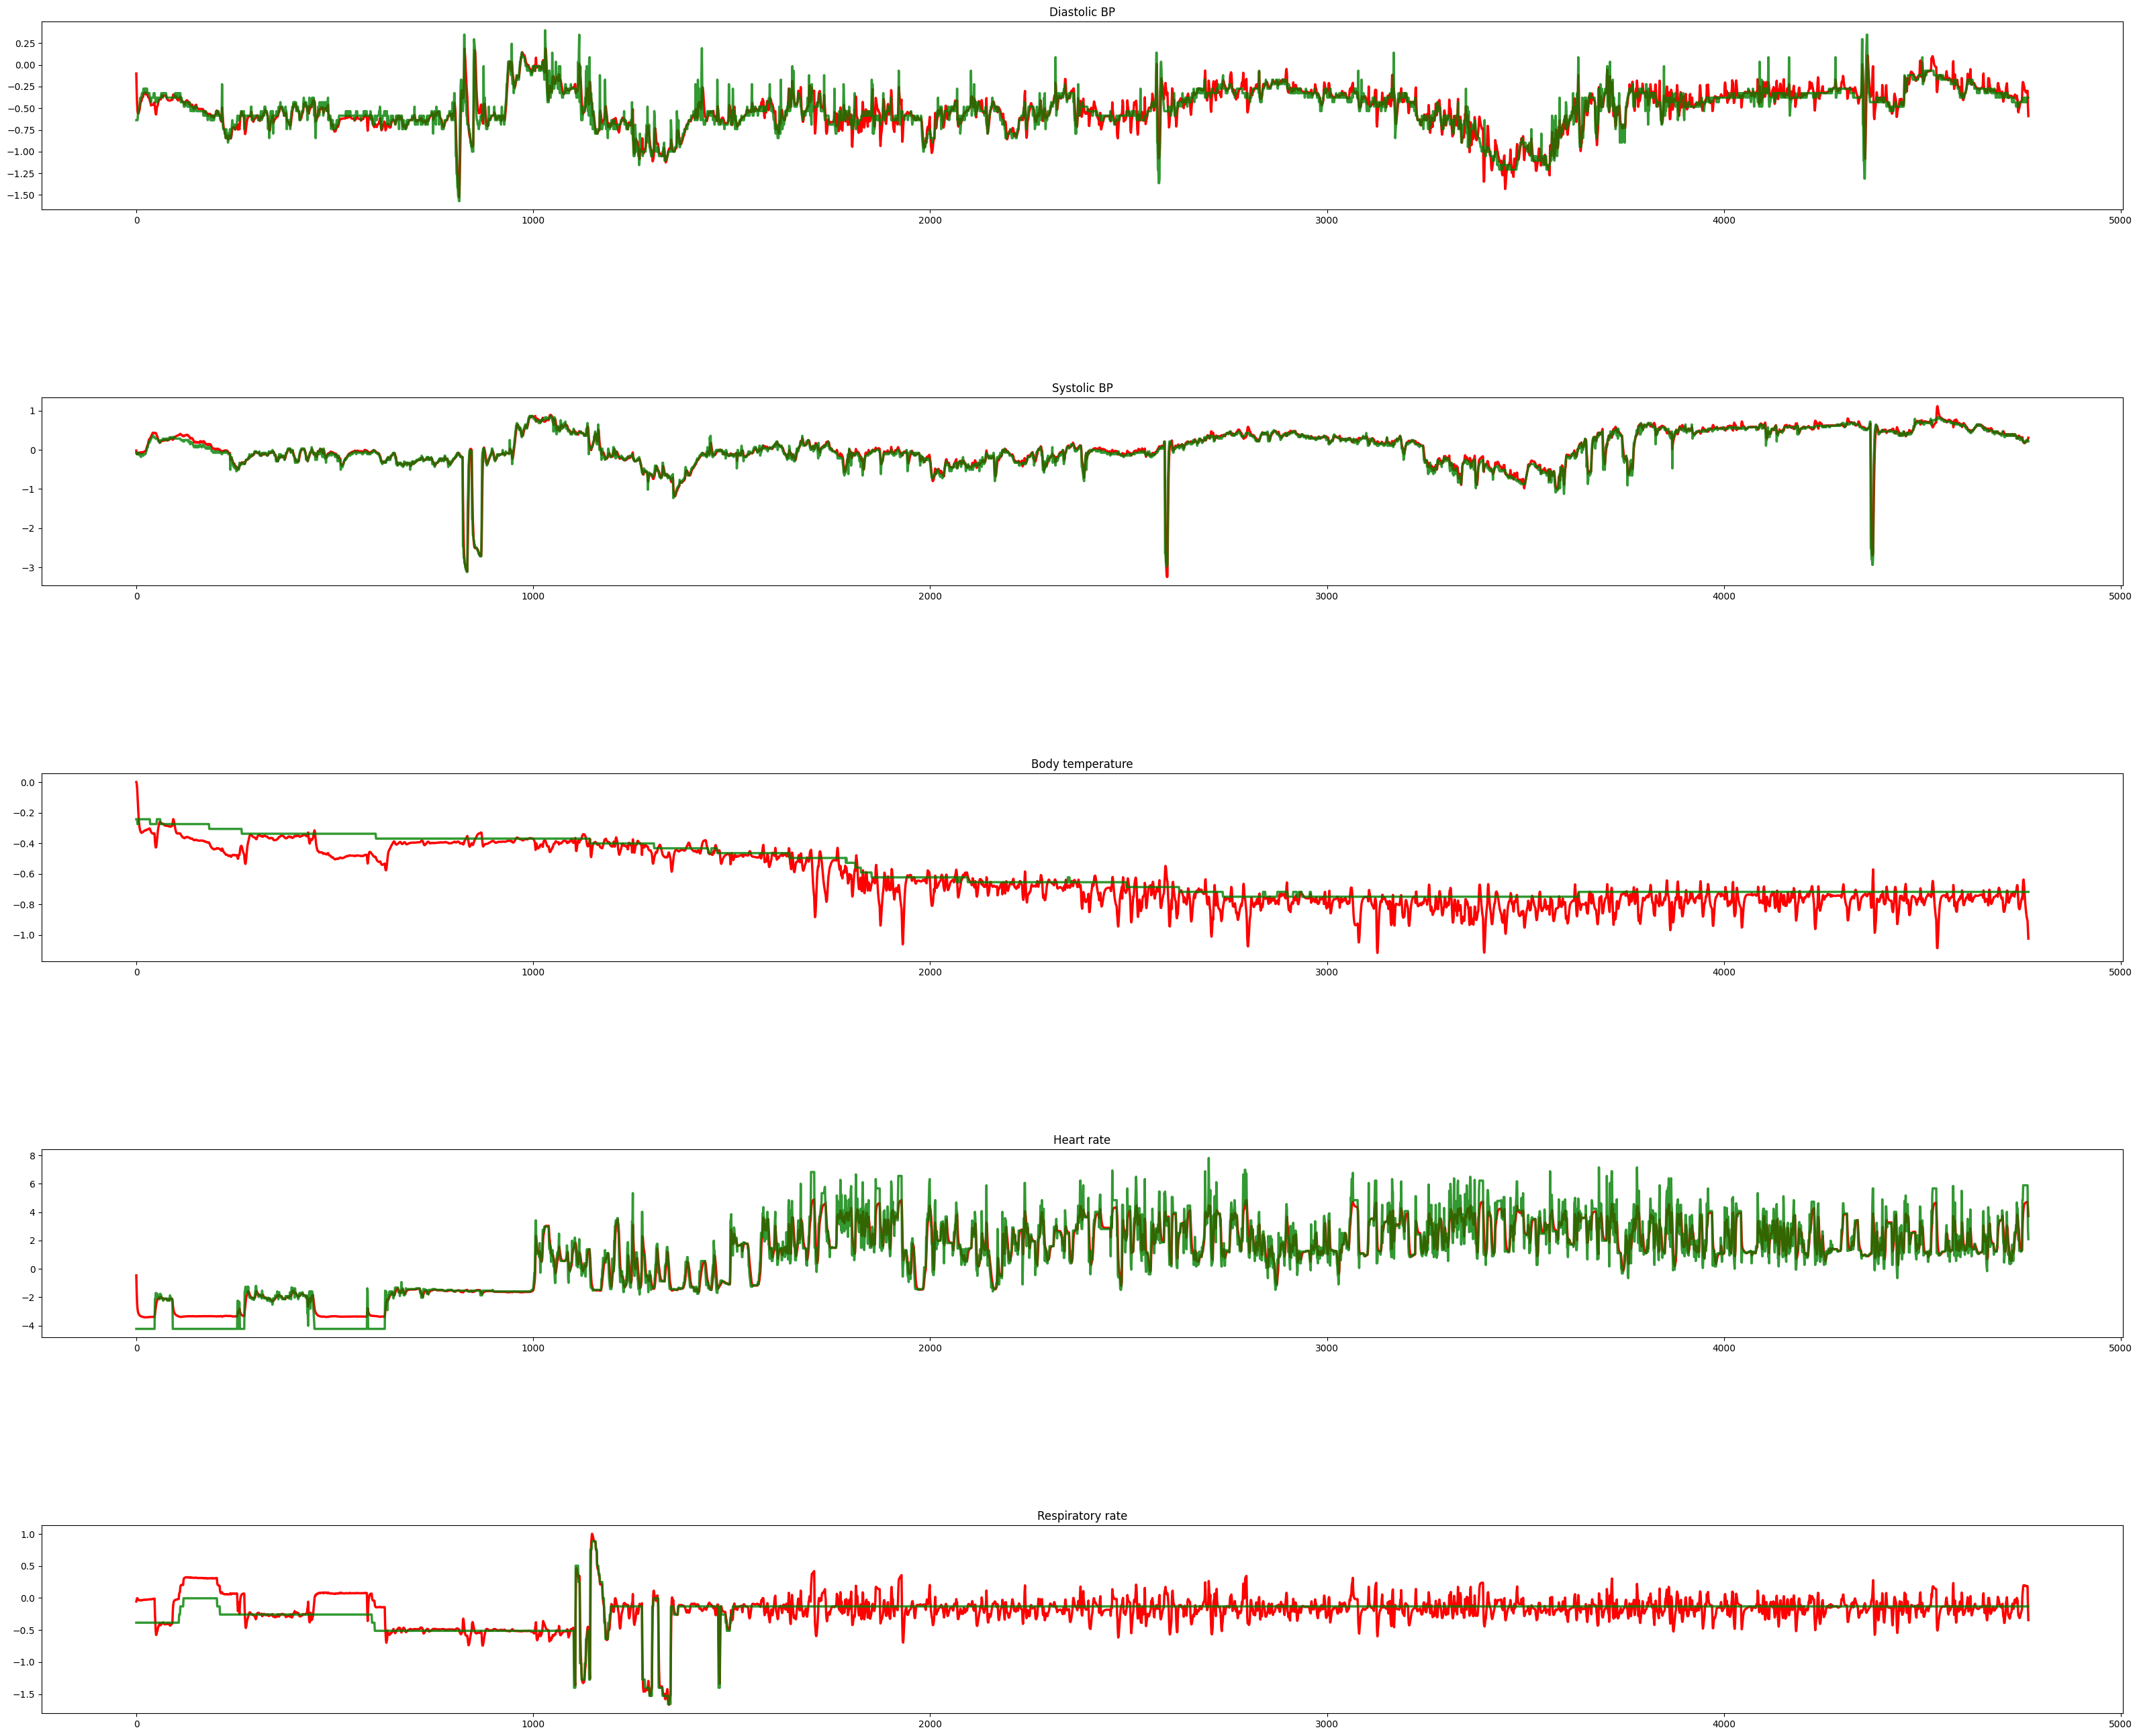

In [19]:
# Let's visualize the presumed anomalies
plot_predict(X_test_asa_eq_3,res_asa_eq_3,n=idx_anomalies_asa_eq_3[20],single=True)

#### Multivariate thresholds

In [20]:
feat_thresholds = select_features_threshold(X_train, res_train, dict_mae_train, perc=.98)
idx_features_anomalies_test  = detect_features_anomalies(X_test, res_test, feat_thresholds, out=True)
idx_features_anomalies_asa_eq_3  = detect_features_anomalies(X_test_asa_eq_3, res_asa_eq_3, feat_thresholds, out=True)


Percentage of anomalies in tested data:

FEATURE 0: 0.02

FEATURE 1: 0.02

FEATURE 2: 0.02

FEATURE 3: 0.02

FEATURE 4: 0.02

Percentage of anomalies in tested data:

FEATURE 0: 0.41

FEATURE 1: 0.17

FEATURE 2: 0.57

FEATURE 3: 0.09

FEATURE 4: 0.16


## Evaluate

### Univariate

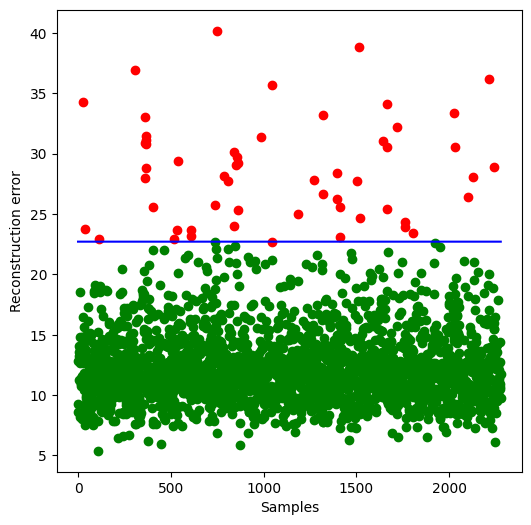

In [21]:
plot_anomalies(X_train,res_train,threshold)

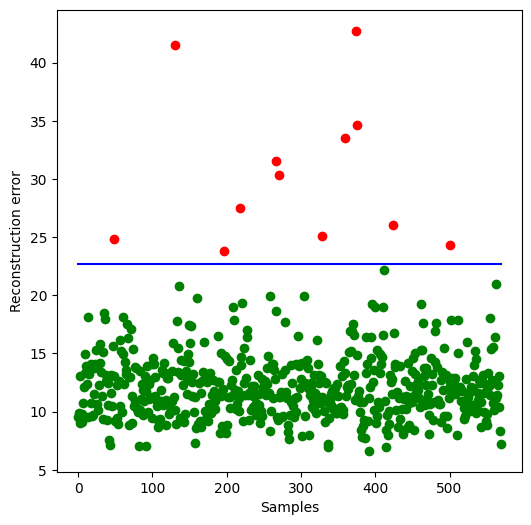

In [22]:
plot_anomalies(X_test,res_test,threshold)

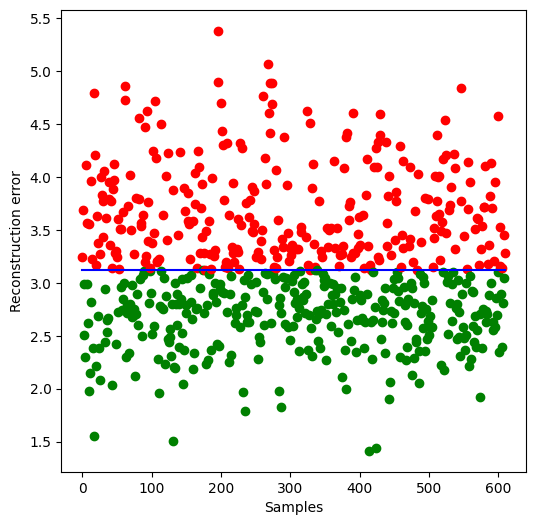

In [23]:
plot_anomalies(X_test_asa_eq_3,res_asa_eq_3,threshold,log=True)

### Multivariate

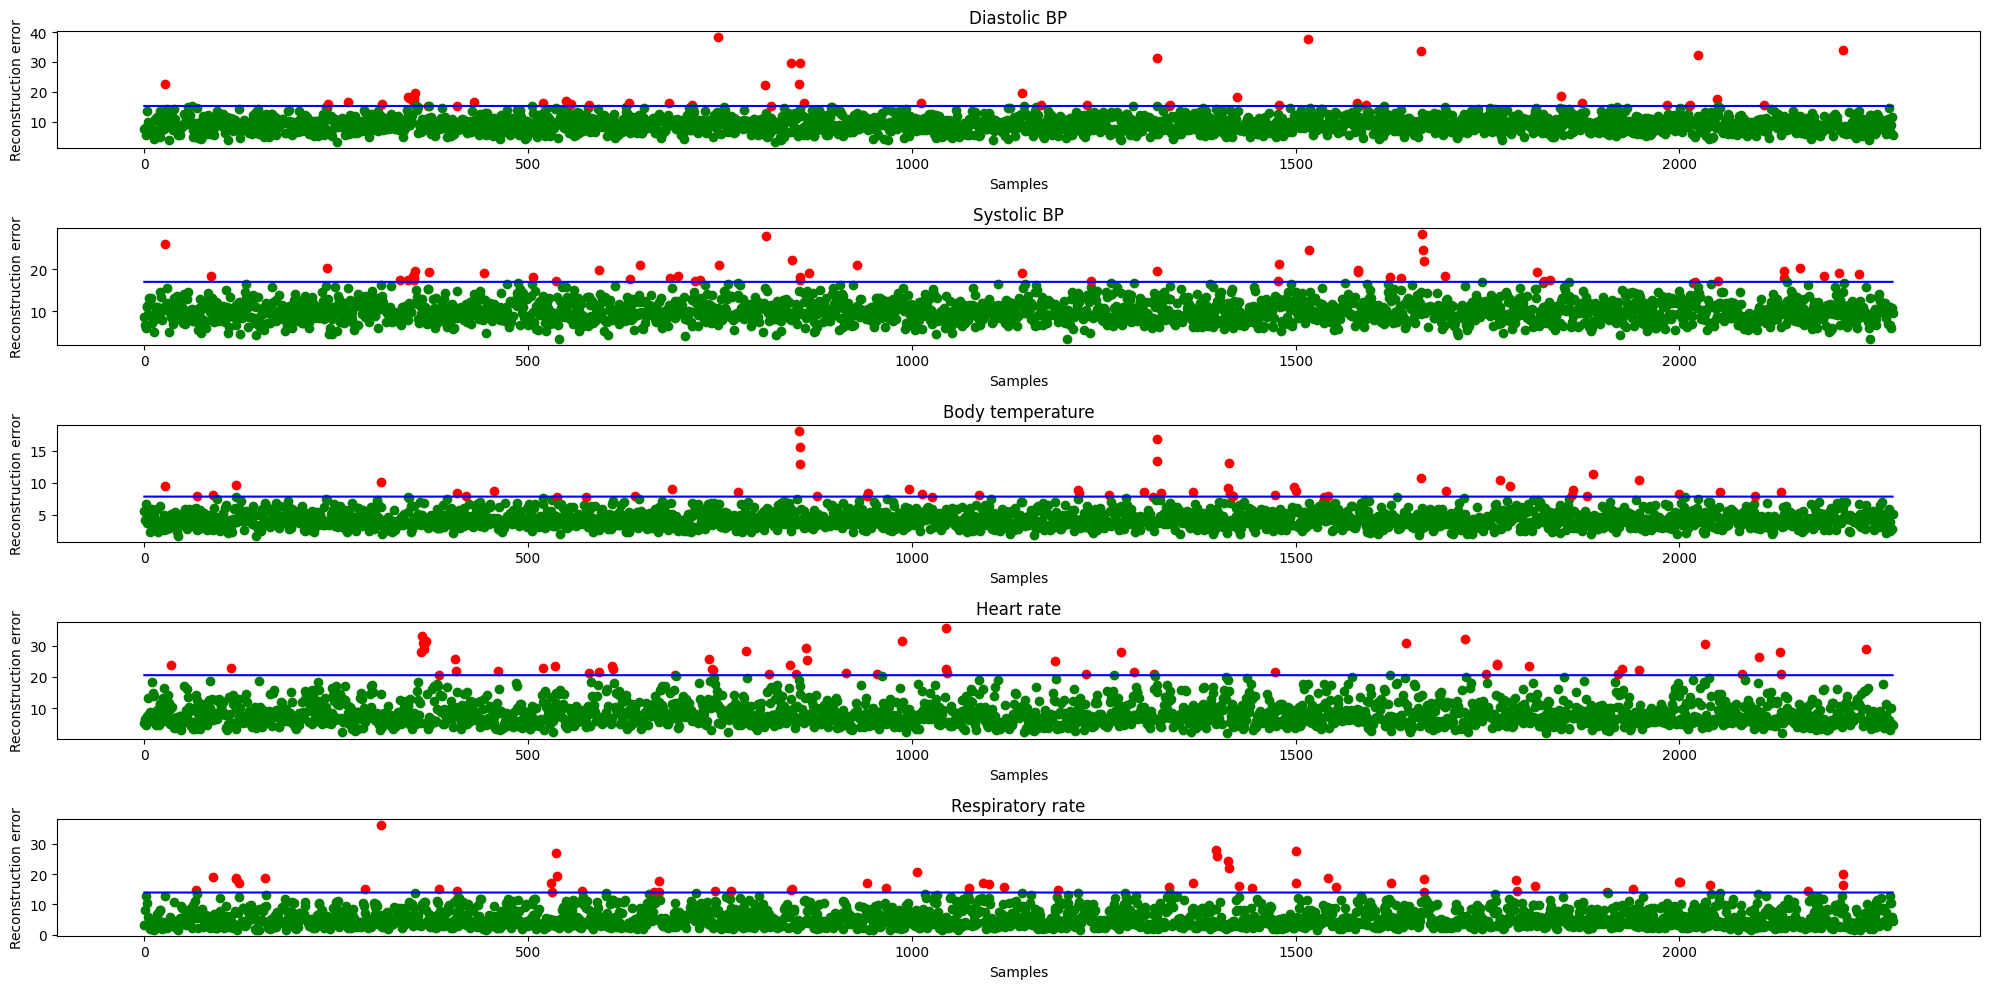

In [24]:
plot_features_anomalies(X_train,res_train,feat_thresholds)

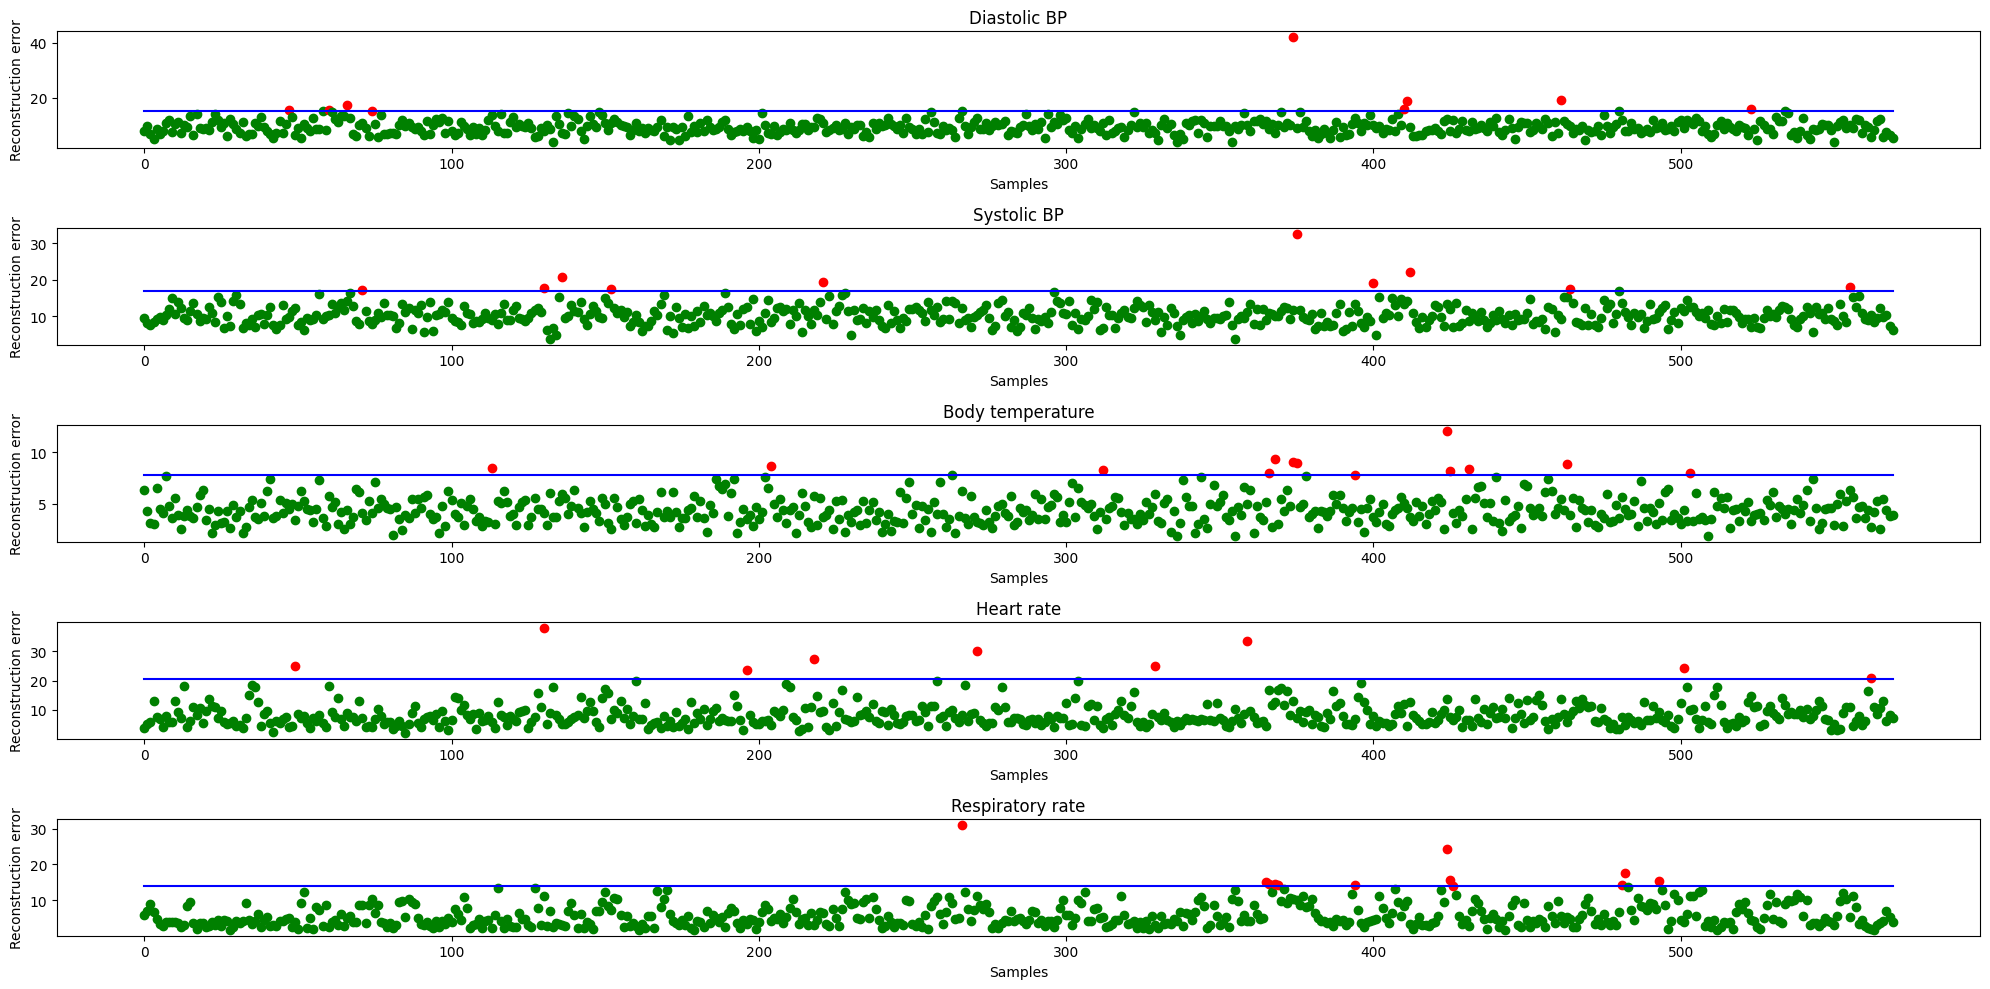

In [25]:
plot_features_anomalies(X_test,res_test,feat_thresholds)

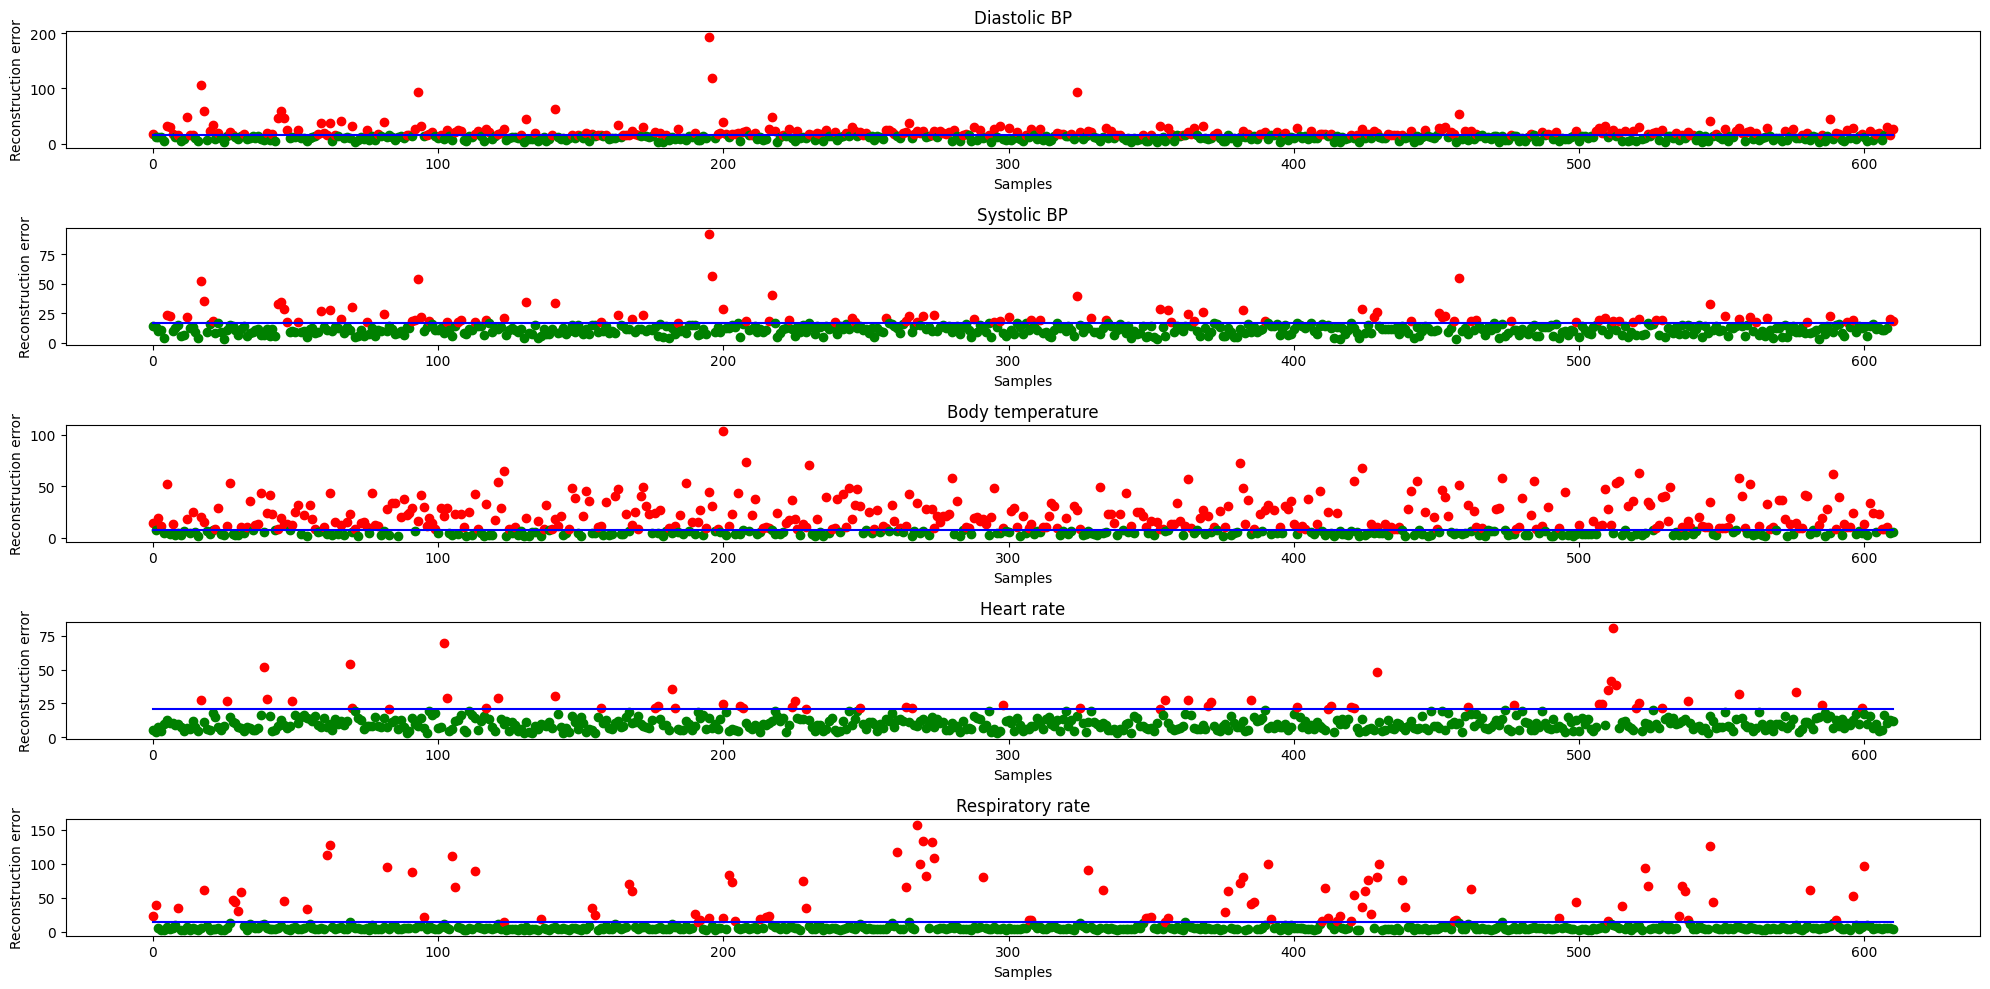

In [26]:
plot_features_anomalies(X_test_asa_eq_3,res_asa_eq_3,feat_thresholds)

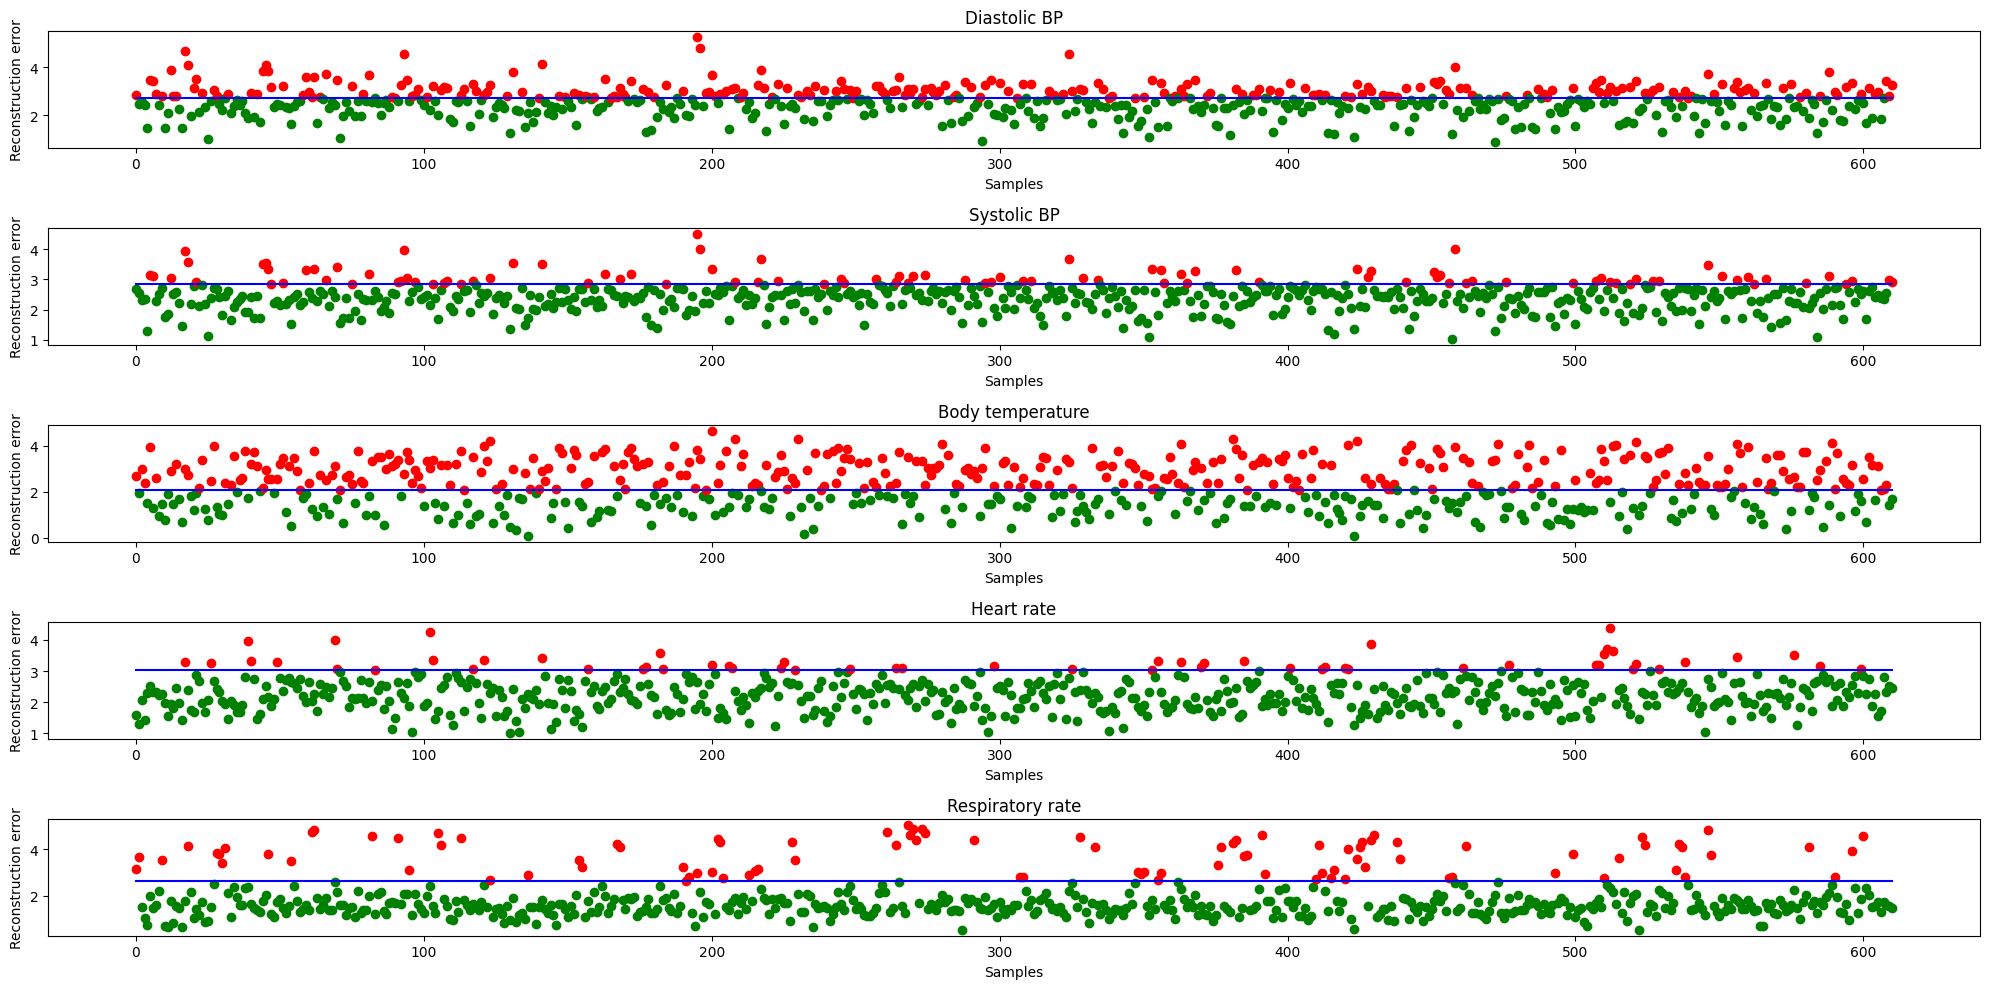

In [27]:
plot_features_anomalies(X_test_asa_eq_3,res_asa_eq_3,feat_thresholds,log=True)